In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import math

from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from pandas.plotting import table

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("../billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year

billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
0,0,1958-09-08,Domenico Modugno,Nel Blu Dipinto Di Blu (Volare),1,1.0,1,6,"F.Migliacci, D.Modugno",Not Listed,Decca,1958
1,1,1958-09-08,The Elegants,Little Star,2,2.0,1,6,"V.Picone, A.Venosa",Not Listed,Apt,1958
2,2,1958-09-08,The Everly Brothers,Bird Dog,3,3.0,3,6,B.Bryant,Not Listed,Cadence,1958
3,3,1958-09-08,Jimmy Clanton And His Rockets,Just A Dream,4,4.0,4,6,Not Listed,Not Listed,Ace,1958
4,4,1958-09-08,Perez Prado And His Orchestra,Patricia,5,6.0,2,6,"B.Marcus, P.Prado",Not Listed,RCA Victor,1958


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["top_position"] = billboard_hot_100.groupby(
    ["artist", "song_name"])["position"].transform("min")

In [6]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

In [7]:
df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

100%|██████████| 30408/30408 [00:44<00:00, 678.96it/s]


In [8]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("last")["position"]

C:\Users\cutie\AppData\Local\Temp\ipykernel_6600\3272273204.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
C:\Users\cutie\AppData\Local\Temp\ipykernel_6600\3272273204.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["last_position"] = billboard_hot_100.sort_values(


In [9]:
billboard_hot_100_copy = billboard_hot_100.copy()
billboard_hot_100 = billboard_hot_100.groupby(
    ["artist", "song_name"])["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "year", "first_position", "last_position"].first().reset_index()

C:\Users\cutie\AppData\Local\Temp\ipykernel_6600\4046987392.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100 = billboard_hot_100.groupby(


In [10]:
billboard_hot_100 = billboard_hot_100[(billboard_hot_100["year"] >= 1959) & (billboard_hot_100["year"] <= 2022)]

## Clustering the songs based on the features

In [11]:
# https://napsterinblue.github.io/notes/machine_learning/unsupervised/basic_evaluation_metrics/
def wss_score(model, X):
    sse = 0
    centroids = model.cluster_centers_    

    for point in X:
        centroid = centroids[model.predict(point.reshape(1, -1))]
        sse += np.linalg.norm((centroid - point))
    
    return sse

100%|██████████| 13/13 [01:45<00:00,  8.09s/it]


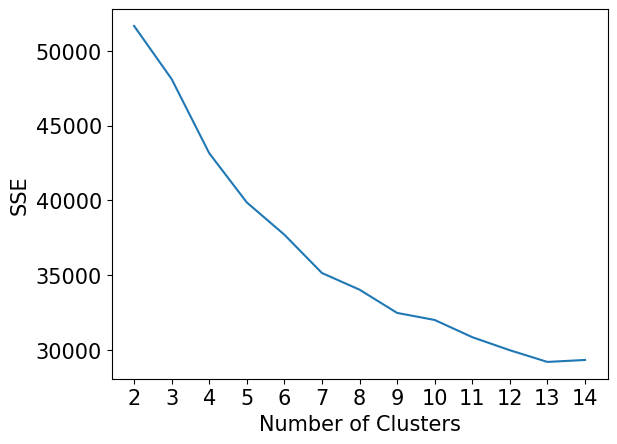

In [12]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

sse = []
for k in tqdm(range(2, 15)):
    kmeans = KMeans(n_clusters=k, n_init="auto")
    scaler = StandardScaler()
    X = scaler.fit_transform(billboard_hot_100[features])
    kmeans.fit(X)
    sse.append(wss_score(kmeans, X))

plt.plot(range(2, 15), sse)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.savefig("figures/kmeans_sse.pdf", format="pdf")
plt.show()

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(billboard_hot_100[features])

model = KMeans(n_clusters=6, n_init="auto")
model.fit(X)

y_clusters = model.predict(X)

In [14]:
billboard_hot_100["cluster"] = y_clusters
billboard_hot_100_new = billboard_hot_100[["artist", "song_name", "cluster"]].merge(billboard_hot_100_copy, on=["artist", "song_name"], how="left")

In [15]:
from numpy import unique

unique_clusters = unique(y_clusters)

In [16]:
rows_to_add = []

grouped = billboard_hot_100_new.groupby(["artist", "song_name"])

for name, group in tqdm(grouped):
    max_week = group["first_day_of_the_week"].max()

    for row_index, row in group.iterrows():
        if row["first_day_of_the_week"] == max_week:
            week = row["first_day_of_the_week"] + timedelta(weeks=1)

            while week <= (max_week + timedelta(weeks=50)):
                rows_to_add.append({
                    "artist": row["artist"],
                    "song_name": row["song_name"],
                    "weeks_on_chart": row["weeks_on_chart"],
                    "position": 101,
                    "first_day_of_the_week": week,
                    "top_position": row["top_position"],
                    "first_position": row["first_position"],
                    "last_position": row["last_position"],
                    "past_weeks": row["past_weeks"],
                    "future_weeks": row["future_weeks"],
                    "max_weeks_on_chart": row["max_weeks_on_chart"],
                    "cluster": row["cluster"],
                    "year": row["year"]
                })
                week += timedelta(weeks=1)

billboard_100_with_empty_weeks = pd.concat([billboard_hot_100_new[["artist", "song_name",
    "weeks_on_chart", "position", "first_day_of_the_week", "top_position",
    "first_position", "last_position", "past_weeks", "future_weeks",
    "max_weeks_on_chart", "cluster"]], pd.DataFrame(rows_to_add)], ignore_index=True)
billboard_100_with_empty_weeks["first_week"] = billboard_100_with_empty_weeks.groupby(["artist", "song_name"])["first_day_of_the_week"].transform("min")

100%|██████████| 30091/30091 [01:38<00:00, 303.96it/s]


100%|██████████| 6/6 [00:35<00:00,  5.98s/it]


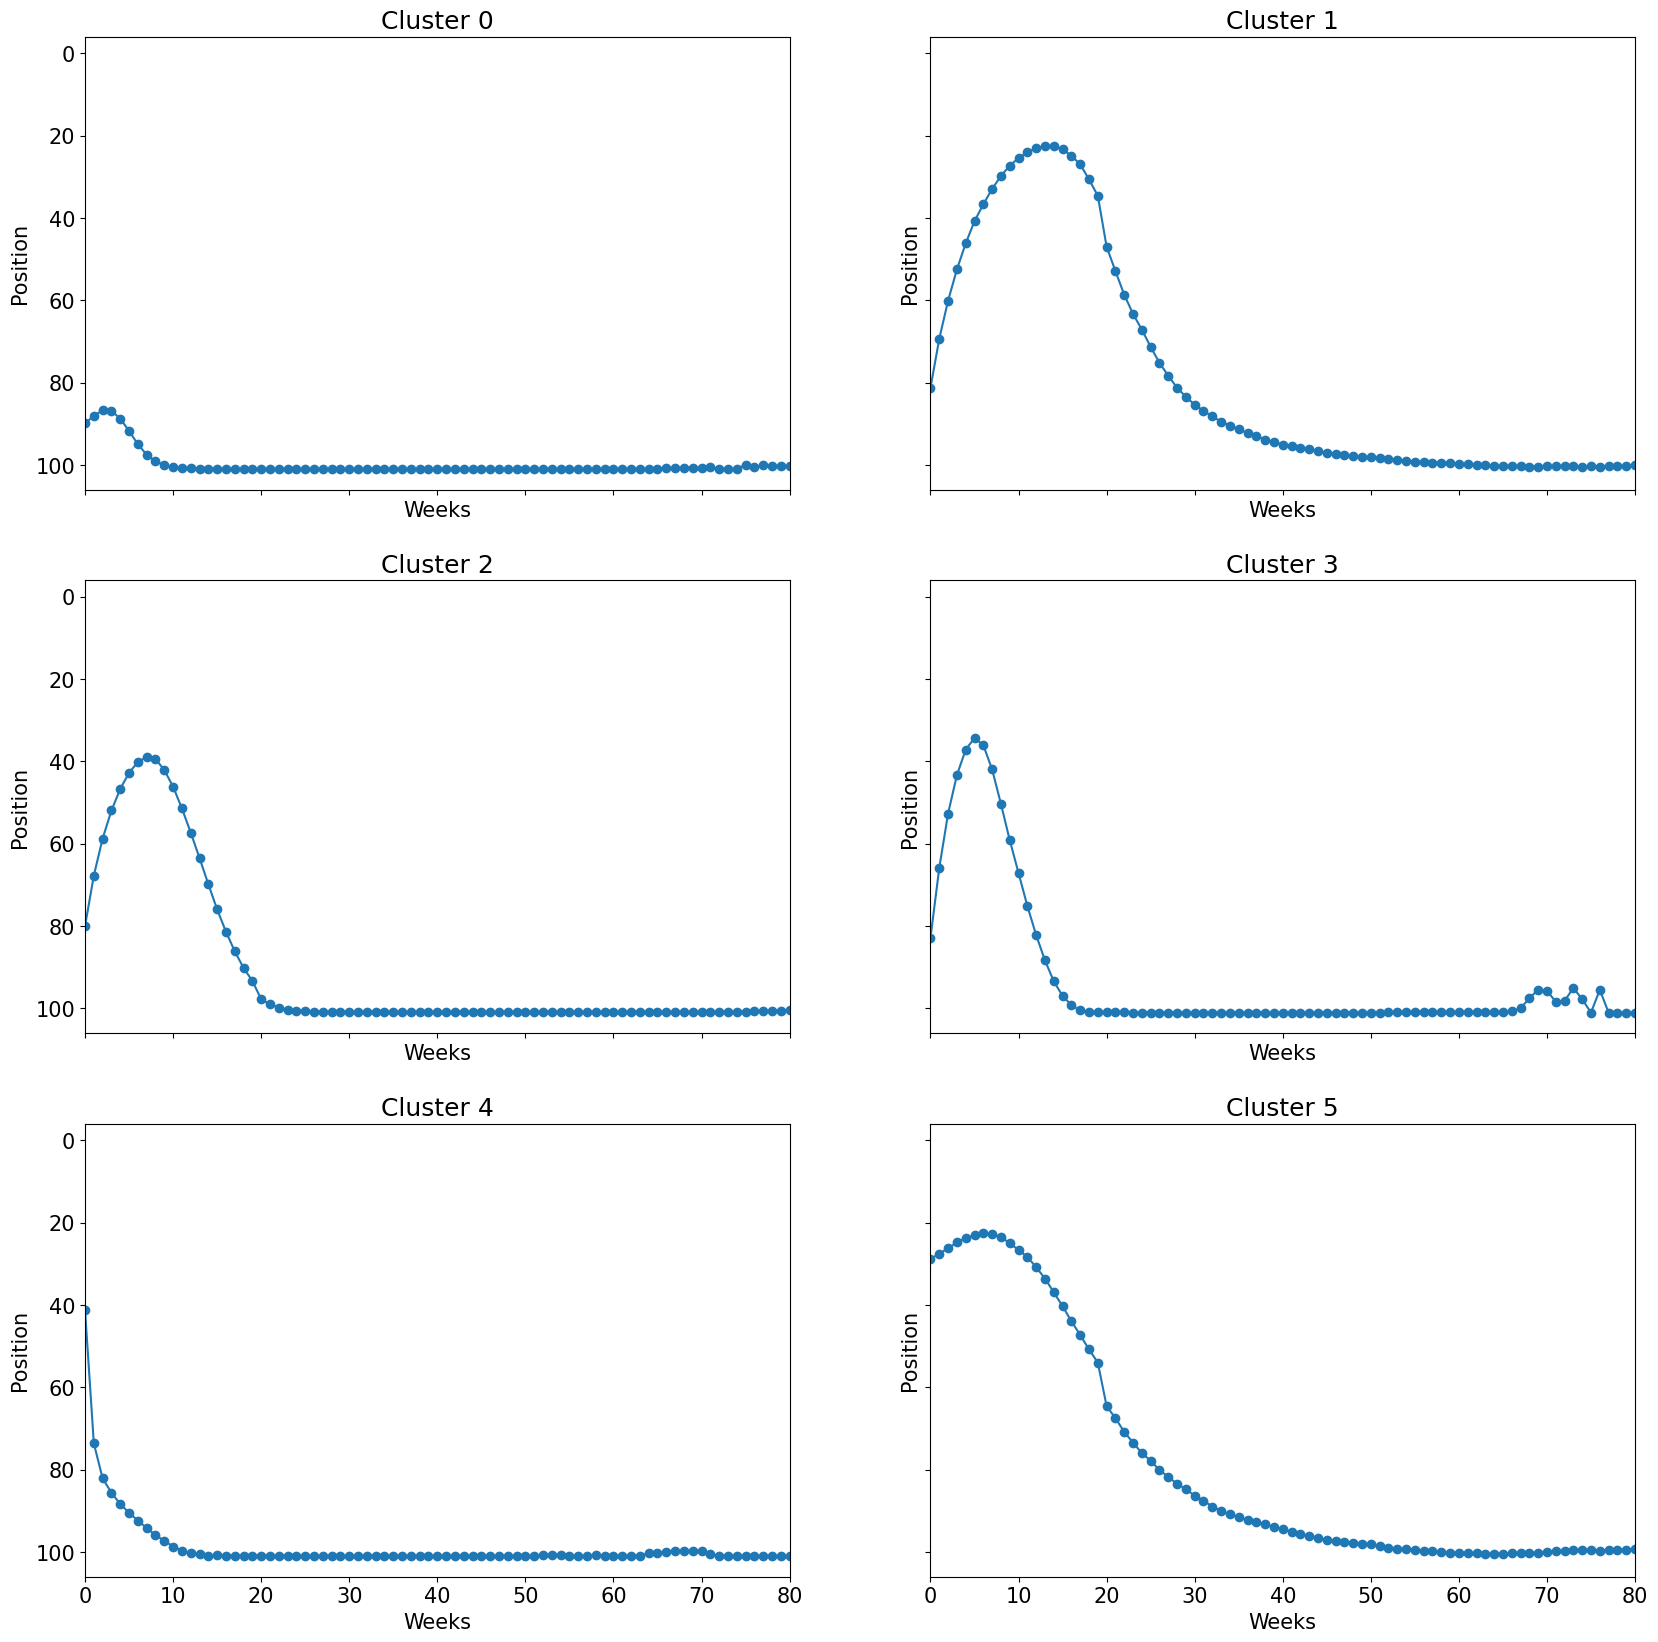

In [17]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for cluster in tqdm(unique_clusters):
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()
        
    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()

    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)

    axes[row_i, col_i].plot(songs_from_cluster.groupby("first_day_of_the_week")["position"].mean(),
            marker='o')
        
    axes[row_i, col_i].set_title(f"Cluster {cluster}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1

plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.savefig("figures/average_cluster_trajectories.pdf", format="pdf")
plt.show()

100%|██████████| 1000/1000 [00:46<00:00, 21.54it/s]


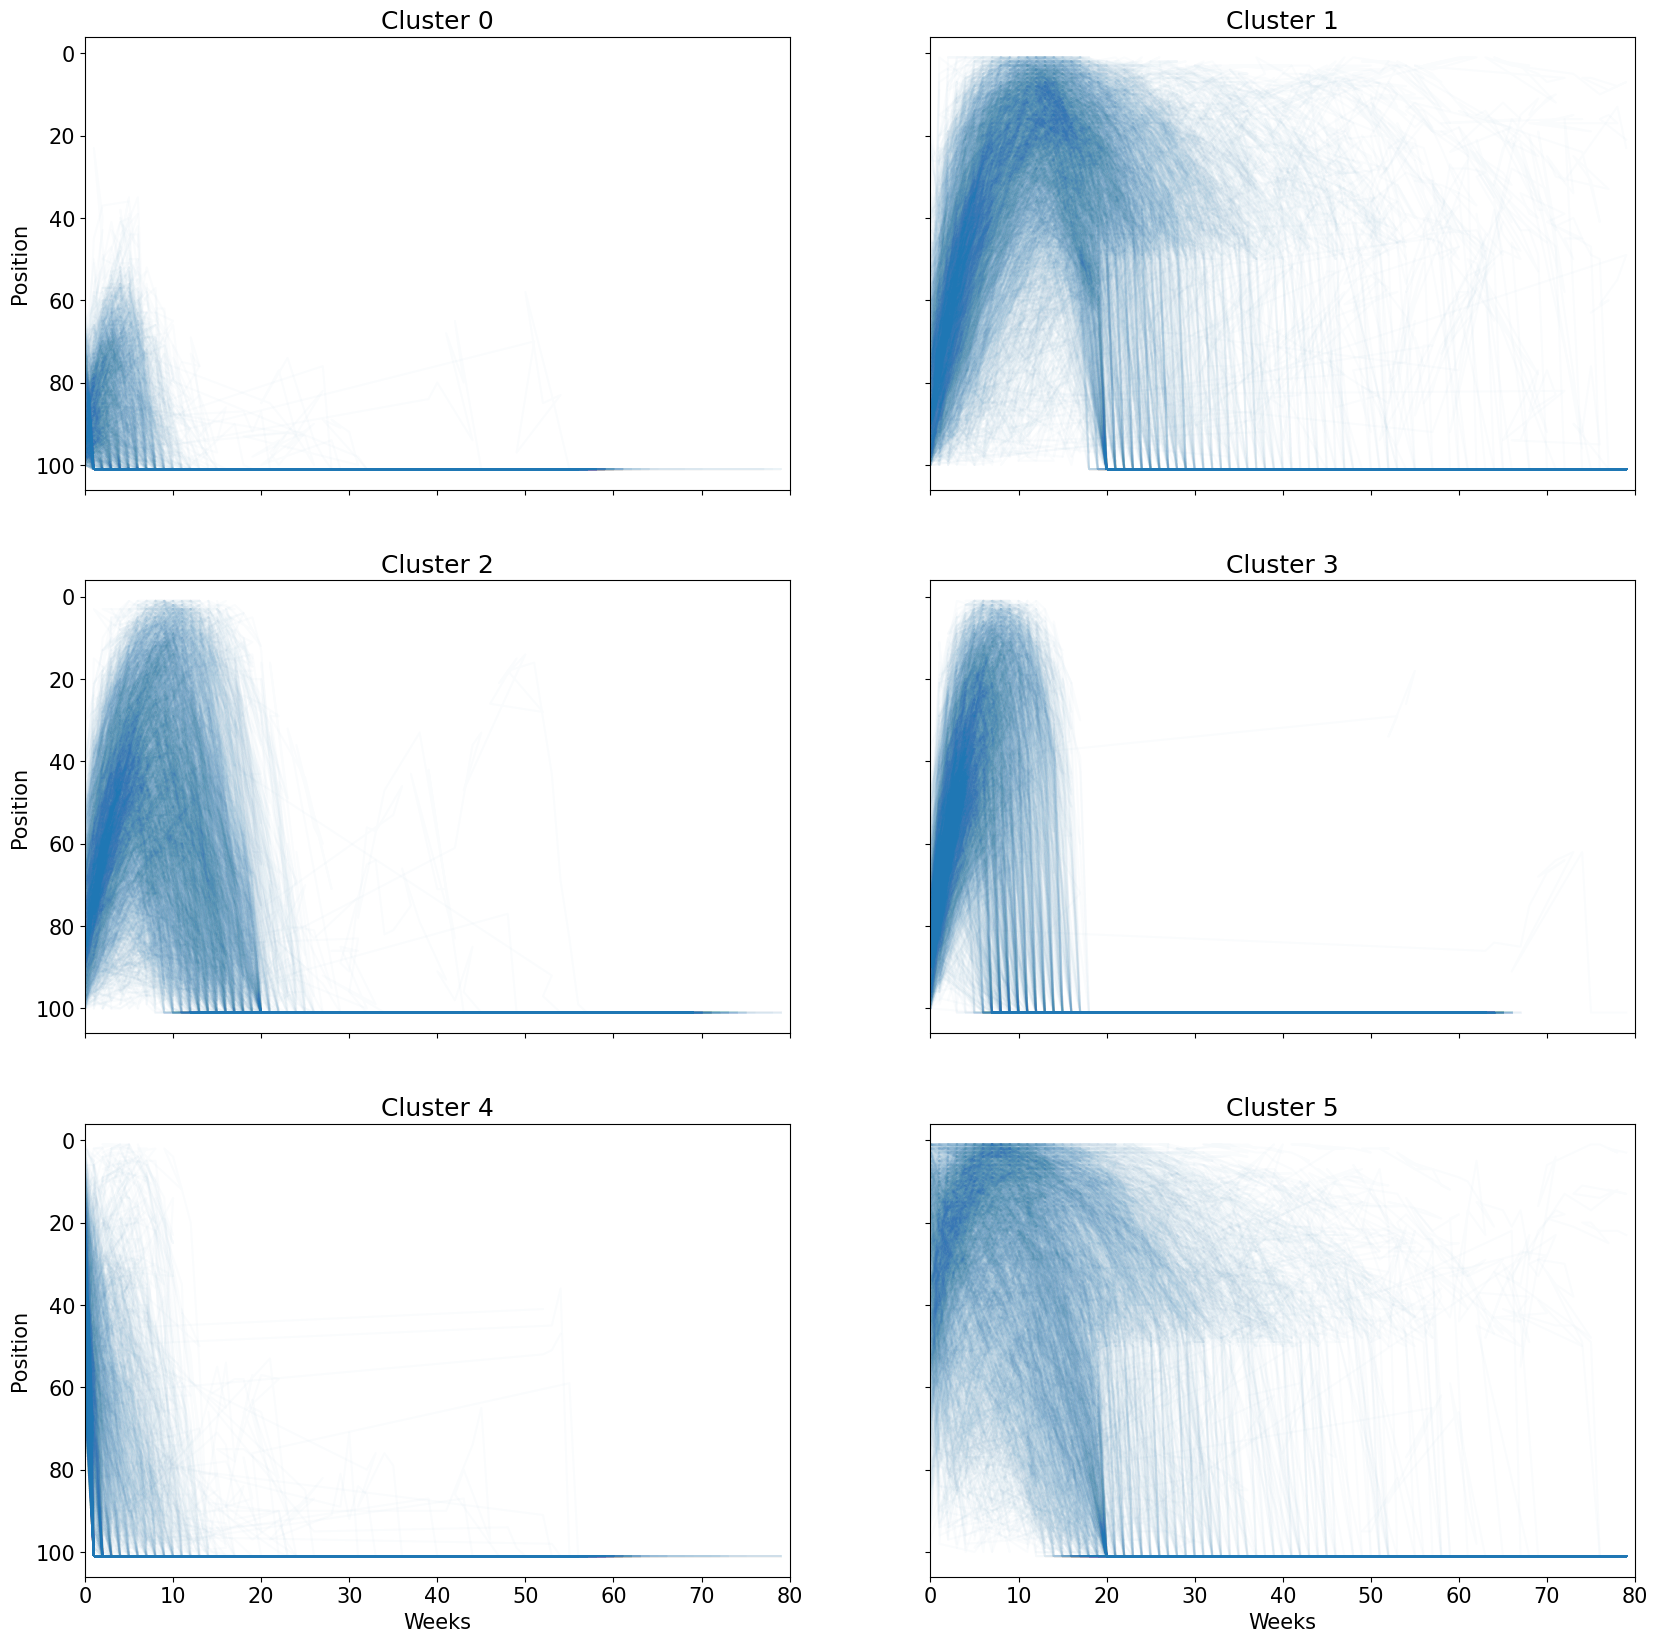

In [18]:
fig, axes = plt.subplots(math.ceil(len(unique_clusters)/2), 2, figsize=(20, 20), sharex=True, sharey=True)
row_i, col_i = 0, 0

for cluster in unique_clusters:
    songs_from_cluster = billboard_100_with_empty_weeks[billboard_100_with_empty_weeks['cluster'] == cluster].copy()
        
    min_first_week = songs_from_cluster["first_day_of_the_week"].min().to_pydatetime()

    songs_from_cluster["first_day_of_the_week"] = songs_from_cluster.apply(lambda row:
        int(((min_first_week + timedelta(
                days=(row["first_day_of_the_week"] - row["first_week"]).days)) - min_first_week).days / 7), axis=1)

    songs_from_cluster = songs_from_cluster[songs_from_cluster["first_day_of_the_week"] < 80]
    songs_from_cluster.set_index("first_day_of_the_week", inplace=True)

    first_2000_songs = [g[1] for g in list(songs_from_cluster.groupby(["artist", "song_name"]))[:1000]]
    for song in tqdm(first_2000_songs):
        song["position"].plot(ax=axes[row_i, col_i], alpha=0.02, color="C0")
        
    axes[row_i, col_i].set_title(f"Cluster {cluster}")
    axes[row_i, col_i].set_xlabel("Weeks")
    axes[row_i, col_i].set_ylabel("Position")

    col_i += 1
    if col_i == 2:
        col_i = 0
        row_i += 1
 
plt.xlim(0, 80)
plt.gca().invert_yaxis()
plt.savefig("figures/cluster_trajectories.pdf", format="pdf")
plt.show()

## Percentage of each cluster in time

In [19]:
# Spotify creation date
spotify_creation_date = pd.to_datetime("2008-01-01", infer_datetime_format=True)

# Youtube creation date
youtube_creation_date = pd.to_datetime("2005-02-14", infer_datetime_format=True)

# Apple music creation date
apple_music_creation_date = pd.to_datetime("2015-06-30", infer_datetime_format=True)

# CDs creation date
cds_creation_date = pd.to_datetime("1982-08-17", infer_datetime_format=True)

# MP3 creation date
mp3_creation_date = pd.to_datetime("1991-12-01", infer_datetime_format=True)

# iTunes release date
itunes_creation_date = pd.to_datetime("2001-01-09", infer_datetime_format=True)

# Cassettes creation date
cassettes_creation_date = pd.to_datetime("1963-08-30", infer_datetime_format=True)

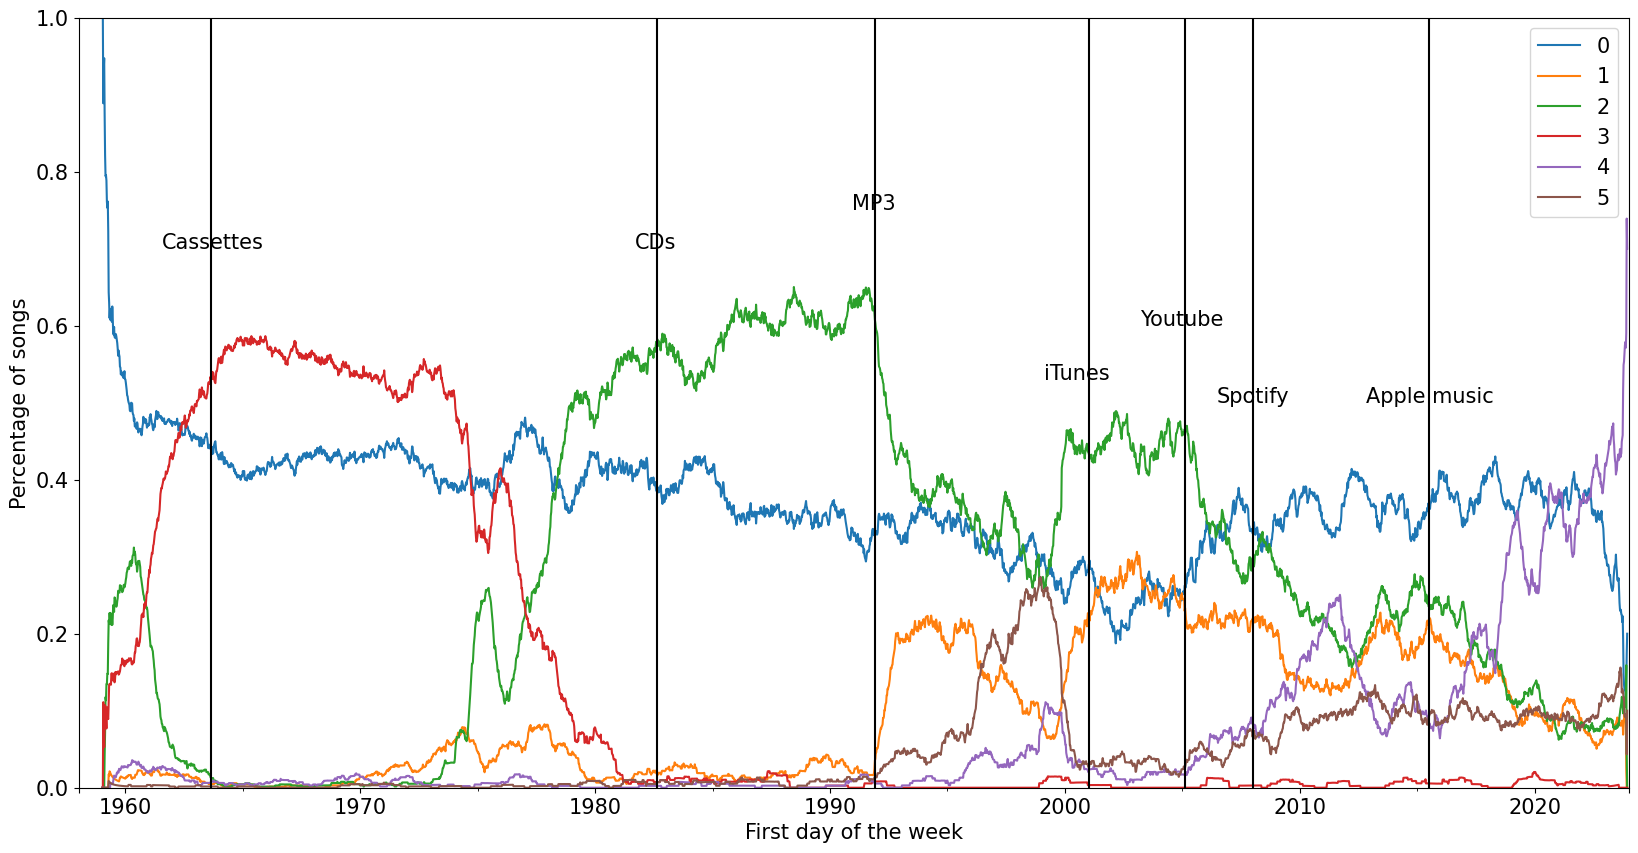

In [20]:
billboard_100_with_empty_weeks_full_data = billboard_100_with_empty_weeks[(billboard_100_with_empty_weeks["year"] >= 1959) & (billboard_100_with_empty_weeks["year"] <= 2022)]
billboard_100_with_empty_weeks_full_data.groupby(["first_day_of_the_week"])["cluster"].value_counts(
    normalize=True).unstack(fill_value=0).stack().sort_index().unstack().plot(figsize=(20, 10))

plt.axvline(spotify_creation_date, color="black")
plt.axvline(youtube_creation_date, color="black")
plt.axvline(apple_music_creation_date, color="black")
plt.axvline(cds_creation_date, color="black")
plt.axvline(mp3_creation_date, color="black")
plt.axvline(itunes_creation_date, color="black")
plt.axvline(cassettes_creation_date, color="black")

plt.text(spotify_creation_date - timedelta(weeks=80), 0.5, "Spotify")
plt.text(youtube_creation_date - timedelta(weeks=100), 0.6, "Youtube")
plt.text(apple_music_creation_date - timedelta(weeks=140), 0.5, "Apple music")
plt.text(cds_creation_date - timedelta(weeks=50), 0.7, "CDs")
plt.text(mp3_creation_date - timedelta(weeks=50), 0.75, "MP3")
plt.text(itunes_creation_date - timedelta(weeks=100), 0.53, "iTunes")
plt.text(cassettes_creation_date - timedelta(weeks=110), 0.7, "Cassettes")

plt.ylabel("Percentage of songs")
plt.xlabel("First day of the week")
plt.xlim(datetime(1958, 1, 1), datetime(2024, 1, 1))
plt.ylim(0, 1)
plt.legend()
plt.savefig("figures/percentage_of_songs_by_cluster.pdf", format="pdf")
plt.show()

Cluster 0
       weeks_on_chart     past_weeks   future_weeks  first_position  \
count   576100.000000  576100.000000  576100.000000   576100.000000   
mean         4.615952       3.234421       1.381878       89.869467   
std          2.949876       2.002253       1.755538        8.172975   
min          1.000000       1.000000       0.000000       61.000000   
25%          2.000000       1.000000       0.000000       85.000000   
50%          4.000000       3.000000       1.000000       91.000000   
75%          7.000000       5.000000       2.000000       97.000000   
max         15.000000      13.000000      13.000000      100.000000   

       last_position   top_position  
count  576100.000000  576100.000000  
mean       88.586096      78.523781  
std        10.110349      13.745990  
min        54.000000      20.000000  
25%        82.000000      68.000000  
50%        92.000000      80.000000  
75%        97.000000      90.000000  
max       100.000000     100.000000  
Cluster 

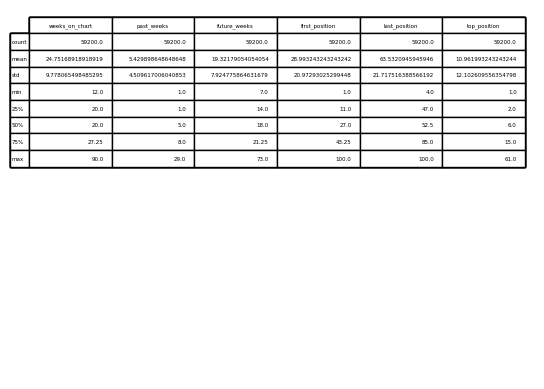

In [21]:
for cluster in unique_clusters:
    songs_from_cluster = billboard_100_with_empty_weeks_full_data[billboard_100_with_empty_weeks_full_data['cluster'] == cluster].copy()
    print(f"Cluster {cluster}")
    cluster_describe = songs_from_cluster[["weeks_on_chart", "past_weeks", "future_weeks", "first_position", "last_position", "top_position"]].describe()
    print(cluster_describe)

    #https://stackoverflow.com/questions/48158688/save-pandas-describe-for-human-readibility
    #create a subplot without frame
    plot = plt.subplot(111, frame_on=False)

    #remove axis
    plot.xaxis.set_visible(False) 
    plot.yaxis.set_visible(False) 

    #create the table plot and position it in the upper left corner
    table(plot, cluster_describe, loc='upper right')
    #save the plot as a png file
    plt.savefig(f'figures/cluster_{cluster}.pdf', format="pdf")
